In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [26]:
# 데이터 로드
digits = datasets.load_digits()
X = digits.images.reshape((len(digits.images), -1))  # (n_samples, 64)
y = digits.target


In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [28]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [45]:
# 2. DNN 모델 정의
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

model = DNN()

In [46]:
# 3. 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [47]:
# 4. EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5)

In [48]:
# 5. 학습 루프 + EarlyStopping
train_losses = []
val_losses = []
epochs = 200

for epoch in range(epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # 검증 손실 계산
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())
    
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    early_stopping(val_loss.item())
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

Epoch [1/200] - Train Loss: 2.3027, Val Loss: 2.2836
Epoch [2/200] - Train Loss: 2.2749, Val Loss: 2.2574
Epoch [3/200] - Train Loss: 2.2476, Val Loss: 2.2316
Epoch [4/200] - Train Loss: 2.2205, Val Loss: 2.2058
Epoch [5/200] - Train Loss: 2.1934, Val Loss: 2.1797
Epoch [6/200] - Train Loss: 2.1659, Val Loss: 2.1528
Epoch [7/200] - Train Loss: 2.1376, Val Loss: 2.1249
Epoch [8/200] - Train Loss: 2.1084, Val Loss: 2.0959
Epoch [9/200] - Train Loss: 2.0780, Val Loss: 2.0656
Epoch [10/200] - Train Loss: 2.0462, Val Loss: 2.0337
Epoch [11/200] - Train Loss: 2.0127, Val Loss: 2.0002
Epoch [12/200] - Train Loss: 1.9776, Val Loss: 1.9651
Epoch [13/200] - Train Loss: 1.9407, Val Loss: 1.9281
Epoch [14/200] - Train Loss: 1.9020, Val Loss: 1.8895
Epoch [15/200] - Train Loss: 1.8614, Val Loss: 1.8491
Epoch [16/200] - Train Loss: 1.8191, Val Loss: 1.8070
Epoch [17/200] - Train Loss: 1.7750, Val Loss: 1.7632
Epoch [18/200] - Train Loss: 1.7293, Val Loss: 1.7177
Epoch [19/200] - Train Loss: 1.6820, 

In [49]:
# 6. 테스트 정확도 평가
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 96.94%


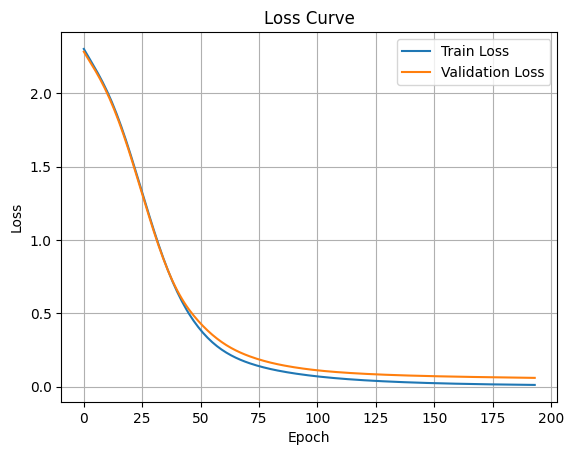

In [50]:
# 7. 시각화: Loss 그래프
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

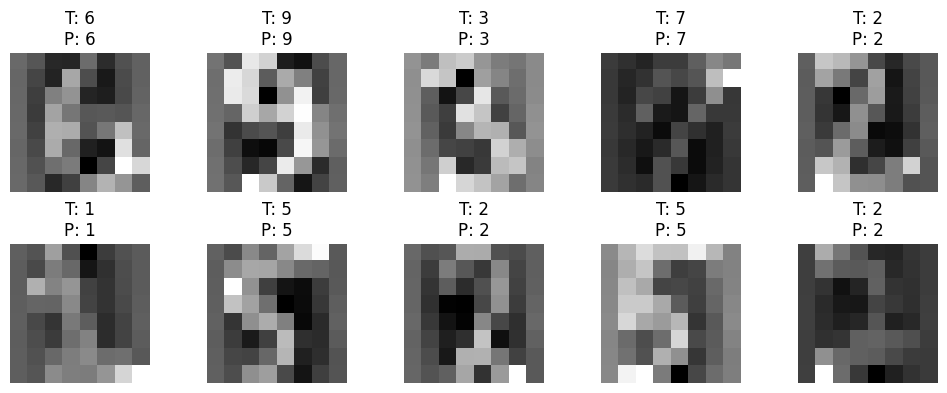

In [51]:
# 8. 테스트 이미지 10개 시각화
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(8, 8).numpy(), cmap='gray')
    plt.title(f"T: {y_test[i].item()}\nP: {predicted[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()